In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
from scipy.linalg import toeplitz, circulant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
plt.style.use('ggplot')
import os
import ipdb
import time
os.system('CUDA_VISIBLE_DEVICES=0')

0

In [2]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum())

In [29]:
def phase_evol(phases, masks, save_name=None, ax=None, action='display'):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        if ax is None:
            fig, ax = plt.subplots()
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = (mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num),
                                 horizontalalignment='left', size='x-small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
    else:
        for i in range(phases.shape[1]):
            ax.plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
    ax.set_ylim([0,2*np.pi])
    plt.tight_layout()
    if action == 'save':
        plt.savefig(save_name + '.png')
    elif action == 'display':
        plt.show()

In [25]:
def batch_circulant(col):
    b, n = col.shape
    C = torch.zeros(b,n,n)
    for i in range(n):
        C[:,:,i] = torch.roll(col,0,i)
    return C

In [3]:
class coupling_network(torch.nn.Module):
    def __init__(self,num_features=32, img_side=32, kernel_size=5):
        super(coupling_network, self).__init__()
        self.img_side = img_side
        self.num_features = num_features
        self.padding = torch.nn.ZeroPad2d(int((kernel_size - 1) / 2))
        self.conv = torch.nn.Conv2d(1,num_features,kernel_size,stride=1)

    def forward(self,x):
        batch_size = x.shape[0]
        x = self.padding(x)
        x = self.conv(x).reshape(batch_size, self.num_features, -1)
        x = torch.einsum('bci,bcj->bij', x, x)/ self.num_features
        return x

In [4]:
class connectivity_cGRU(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256,num_hid_layers=1, transform=None, feedback=False):
        super(connectivity_cGRU, self).__init__()
        self.num_out = num_out
        self.num_hid_units = num_hid_units
        self.num_hid_layers = num_hid_layers
        self.transform = transform
        self.feedback = feedback
        self.triu_ind = torch.triu_indices(row=num_in, col=num_in, offset=1)
        
        gru_in = 2*num_in if feedback else num_in
        self.gru = torch.nn.GRU(gru_in, num_hid_units, num_hid_layers,)
        self.fc = torch.nn.Linear(self.num_hid_units, self.num_out)
        self.relu = torch.nn.ReLU()
        
    def forward(self, batch, h, phase, coupling_strength=.3, alpha=1e-1,
                GRU_steps=10, kuramoto_steps=100, return_connectivities=False, sequential=False, block_size=1024):
        phase_trajectory = []
        connectivities = []
        if self.feedback:
            for t in range(kuramoto_steps):
                data = torch.cat([batch, phase], dim=-1).unsqueeze(0)
                out, h = self.gru(data,h)
                out = self.fc(self.relu(out.squeeze(0)))
                if self.transform == 'softmax':
                    out = softmax(out,dim=-1)
                elif self.transform == 'sigmoid':
                    out = sigmoid(out)

                connectivity = torch.zeros((batch.shape[0], batch.shape[1], batch.shape[1])).to(device)
                connectivity[:,self.triu_ind[0], self.triu_ind[1]] = out
                connectivity += connectivity.transpose(2,1)
                if return_connectivities:
                    connectivities.append(connectivity)
                omega = torch.zeros_like(phase)

                phase = kuramoto_step(phase, connectivity, omega, alpha=alpha, sequential=sequential, block_size=block_size)
                phase_trajectory.append(phase)        

            if return_connectivities:
                return phase_trajectory, connectivities
            else:
                return phase_trajectory
        else:
            data = torch.stack([omega for _ in range(GRU_steps)])
            out, h = self.gru(data, h)

            out = torch.stack([self.fc(self.relu(out[i, ...])) for i in range(GRU_steps)])
            if self.transform == 'softmax':
                out = softmax(out,dim=-1)
            elif self.transform == 'sigmoid':
                out = sigmoid(out)
            connectivity = make_connectivity(out[-1,...])
            if return_connectivities:
                connectivities.append(connectivity)
                
            for t in range(kuramoto_steps):
                phase = kuramoto_step(phase, coupling_strength*connectivity, omega, alpha=alpha)
                phase_trajectory.append(phase)  
                
            if return_connectivities:
                return phase_trajectory, connectivities
            else:
                return phase_trajectory
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_hid_layers, batch_size, self.num_hid_units).zero_()
        return hidden

In [5]:
def circular_moments_batch(phases, masks):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(2)/num_groups
    
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    desynch = 0
    
    for m in np.arange(1, int(np.floor(num_groups/2.)) + 1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2*num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
#     loss = .5*(synch + desynch)
    loss = desynch
    return loss.mean()

In [6]:
# Make data
def make_data(num_samples, num_cells=12, num_textures=4, img_side=32):
    cells_per_texture = int(num_cells / num_textures)
    gray=True
    all_imgs = []
    all_masks = []
    for s in range(num_samples):
        yy = torch.linspace(0,img_side-1, img_side).int()
        xx = torch.linspace(0,img_side-1, img_side).int()
        grid = torch.meshgrid(yy,xx)
        points = torch.randint(0, img_side, size=(num_cells, 2)).float()
        dists = []
        gray_levels = torch.randperm(255)[:num_textures]
        exploded_gray_levels = []
        for i in range(num_textures):
            exploded_gray_levels += int(num_cells / num_textures) * [gray_levels[i]]
        imgs = [exploded_gray_levels[i]*torch.ones((img_side, img_side)) for i in range(num_cells)]
        for p in points:
            dists.append(torch.sqrt((p[0] - grid[0])**2 + (p[1] - grid[1])**2))
        dists = torch.stack(dists)
        masks = [torch.argmin(dists,axis=0) == i for i in range(len(points))]
        composite = torch.stack([mask.unsqueeze(-1)*image for (mask,image) in zip(masks, imgs)]).sum(0)
        stacked_masks = torch.stack(masks)
        eq_masks = torch.stack([stacked_masks[i*cells_per_texture:(i+1)*cells_per_texture].sum(0) for i in range(num_textures)])
        all_imgs.append(composite.mean(-1))
        all_masks.append(eq_masks)
    return torch.stack(all_imgs), torch.stack(all_masks)

In [7]:
def kuramoto_step(phase, coupling, omega, alpha=.01, sequential=False, block_size=128):
    if sequential:
        num_units = phase.shape[-1]
        interactions = torch.tensor([])
        num_blocks = int(num_units / block_size)
        units_computed = 0
        while units_computed < num_units:
            if num_units - units_computed < block_size:
                current_block_size = num_units - units_computed
            else:
                current_block_size = block_size
            phase_diffs = torch.sin(phase[:,units_computed : units_computed + current_block_size].unsqueeze(2) - phase.unsqueeze(1))
            current_coupling = torch.stack([coupling for _ in range(current_block_size)]).transpose(1,0)
            interactions = torch.cat([interactions, (phase_diffs * current_coupling).sum(-1) / float(num_units)], dim=-1)
            units_computed += current_block_size
        delta = alpha * (omega + interactions)
    else:
        phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
        delta = alpha * (omega + (coupling * phase_diffs).mean(1))
    return phase + delta

In [12]:
# Make Data
img_side=10
num_training= 32
num_testing = 32
print('Making data')
training_imgs, training_masks = make_data(num_training, img_side=img_side)
testing_imgs, testing_masks = make_data(num_testing, img_side=img_side)
print('Done')

Making data
Done


In [ ]:
batch_size = 32
num_epochs = 10
kuramoto_steps=100
burn_in_steps=80
num_features=25
lr = 1e-2
alpha = 1e-1
sigma = 1.0
feedback=True
transform=None
num_hid_layers=2
num_hid_units=256
num_units = img_side**2
num_out = int(num_units * (num_units - 1) / 2)
num_batches = 100
recurrent = True
sequential = False
device='cpu'
block_size = 16**2
# num_batches = int(num_training / batch_size)
# cn = coupling_network(num_features=num_features, img_side=32)
cn = connectivity_cGRU(num_units, num_out, num_hid_units=num_hid_units,
                          num_hid_layers=num_hid_layers, transform=transform, feedback=feedback).to(device)
opt = torch.optim.Adam(cn.parameters(), lr=lr)
lh = []
omega = torch.zeros((batch_size, img_side**2))
for n in range(num_batches):
    start = time.time()
    opt.zero_grad()
    batch = (training_imgs[:batch_size,...] / 255.).reshape(batch_size, -1).to(device)
    masks = training_masks[:batch_size,...].reshape(batch_size, 4, -1).to(device)
    phase = torch.normal(np.pi, .1, size=torch.Size((batch_size,num_units))).to(device)
    if recurrent:
        h = cn.init_hidden(batch_size)
        flow = cn.forward(batch, h, phase, sequential=sequential, block_size=block_size)
    else:
        flow = cn.forward(batch)
    flow = torch.stack(flow)
    truncated_flow = flow[burn_in_steps:,...]
    loss = circular_moments_batch(truncated_flow, masks)
    lh.append(loss.detach().cpu().numpy())
    loss.backward()
    opt.step()
    stop = time.time()
    print('Iterations {}. Loss {}. Time: {}'.format(n, lh[-1], stop - start))


Iterations 0. Loss 2.498640537261963. Time: 26.862934350967407
Iterations 1. Loss 2.1173362731933594. Time: 21.27225089073181
Iterations 2. Loss 0.8436897397041321. Time: 19.986913442611694
Iterations 3. Loss 0.4012366831302643. Time: 20.844847679138184
Iterations 4. Loss 0.3710821866989136. Time: 18.762304306030273


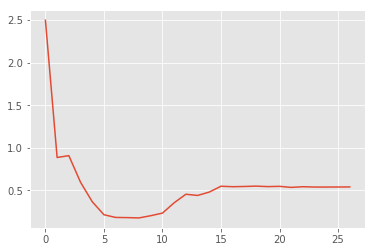

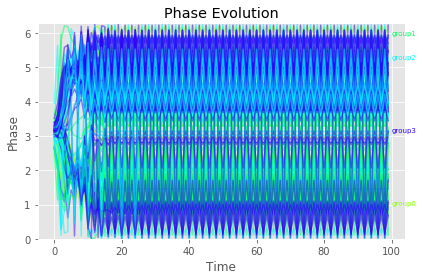

In [35]:
plt.plot(lh)
plt.show()
plt.close()
phase_evol(flow[:,0,:].unsqueeze(1).detach().numpy(),masks[0,...].unsqueeze(0).detach().numpy())